In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd

# Kết nối với Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image


In [ ]:
data_dir = "/content/drive/MyDrive/resolution"  # Đặt đường dẫn đến thư mục chứa class B và C
classes = ["Nematode", "Pink Disease"]
input_dim = 128 * 128  # Kích thước ảnh sau khi resize
latent_dim = 32
batch_size = 64

# Tiền xử lý ảnh
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten ảnh thành vector
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

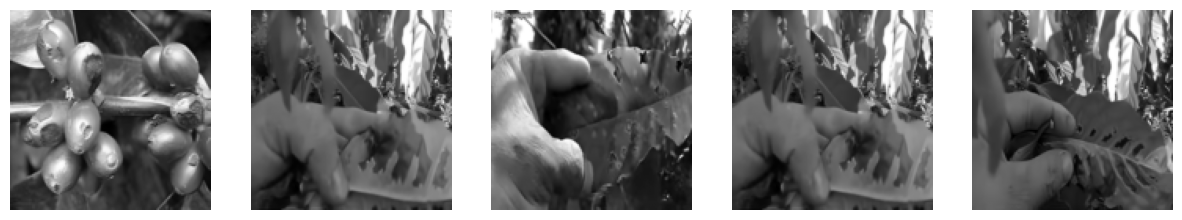

In [ ]:
# Hiển thị một vài sample từ tập dữ liệu đã tiền xử lý
sample_images, _ = next(iter(dataloader))
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(sample_images[i].view(128, 128).cpu().numpy(), cmap="gray")
    axes[i].axis("off")
plt.show()


In [ ]:
class VAE_Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.fc_mu = nn.Linear(128 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(128 * 16 * 16, latent_dim)

    def forward(self, x):
        x = x.view(-1, 1, 128, 128)
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 16 * 16)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 128, 16, 16)
        x = self.deconv(x)
        return x.view(-1, 1, 128, 128)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.fc = nn.Linear(64 * 32 * 32, 1)

    def forward(self, x):
        x = x.view(-1, 1, 128, 128)
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        return torch.sigmoid(self.fc(x))

In [ ]:
def vae_loss(x, x_hat, mu, logvar):
    recon_loss = nn.MSELoss()(x_hat, x)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.1 * kl_loss

def wasserstein_loss(D, x_real, x_fake):
    return -torch.mean(D(x_real).view(-1)) + torch.mean(D(x_fake).view(-1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_encoder = VAE_Encoder(input_dim, latent_dim).to(device)
generator = Generator(latent_dim, input_dim).to(device)
discriminator = Discriminator().to(device)

vae_optimizer = optim.Adam(list(vae_encoder.parameters()) + list(generator.parameters()), lr=0.001)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    for batch in dataloader:
        x_real, _ = batch
        x_real = x_real.to(device)

        # Huấn luyện VAE
        mu, logvar = vae_encoder(x_real)
        z = reparameterize(mu, logvar)
        x_hat = generator(z).view_as(x_real)
        vae_optimizer.zero_grad()
        loss_vae = vae_loss(x_real, x_hat, mu, logvar)
        loss_vae.backward()
        vae_optimizer.step()

        # Huấn luyện Discriminator với Wasserstein Loss
        z_fake = torch.randn(x_real.shape[0], latent_dim).to(device)
        x_fake = generator(z_fake)
        discriminator_optimizer.zero_grad()
        loss_discriminator = wasserstein_loss(discriminator, x_real, x_fake)
        loss_discriminator.backward()
        discriminator_optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], VAE Loss: {loss_vae:.4f}, D Loss: {loss_discriminator:.4f}")

Epoch [1/50], VAE Loss: 0.5407, D Loss: -0.0056
Epoch [2/50], VAE Loss: 0.5238, D Loss: -0.6060
Epoch [3/50], VAE Loss: 0.4673, D Loss: -0.9356
Epoch [4/50], VAE Loss: 0.4269, D Loss: -0.9939
Epoch [5/50], VAE Loss: 0.3842, D Loss: -0.9991
Epoch [6/50], VAE Loss: 0.3428, D Loss: -0.9997
Epoch [7/50], VAE Loss: 0.3082, D Loss: -0.9998
Epoch [8/50], VAE Loss: 0.2692, D Loss: -0.9995
Epoch [9/50], VAE Loss: 0.2326, D Loss: -0.9933
Epoch [10/50], VAE Loss: 0.2010, D Loss: -0.9843
Epoch [11/50], VAE Loss: 0.1733, D Loss: -0.9701
Epoch [12/50], VAE Loss: 0.1500, D Loss: -0.9778
Epoch [13/50], VAE Loss: 0.1336, D Loss: -0.9294
Epoch [14/50], VAE Loss: 0.1218, D Loss: -0.9250
Epoch [15/50], VAE Loss: 0.1085, D Loss: -0.6808
Epoch [16/50], VAE Loss: 0.1018, D Loss: -0.7329
Epoch [17/50], VAE Loss: 0.0950, D Loss: -0.6254
Epoch [18/50], VAE Loss: 0.0895, D Loss: -0.5827
Epoch [19/50], VAE Loss: 0.0836, D Loss: -0.4851
Epoch [20/50], VAE Loss: 0.0795, D Loss: -0.4335
Epoch [21/50], VAE Loss: 0.07

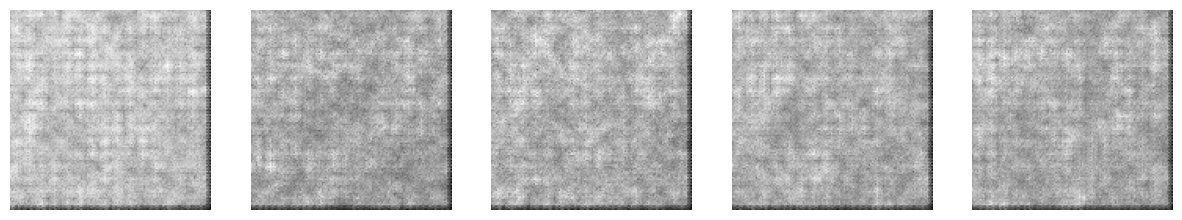

In [ ]:
def generate_synthetic_data(num_samples):
    generator.eval()
    with torch.no_grad():
        z_new = torch.randn(num_samples, latent_dim).to(device)
        synthetic_data = generator(z_new).cpu().numpy()
    return synthetic_data

new_data = generate_synthetic_data(1000)
np.save("augmented_data.npy", new_data)

# Hiển thị 5 ảnh
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(new_data[i].reshape(128, 128), cmap="gray")
    axes[i].axis("off")
plt.show()
